Imports

In [1]:
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import csv
import datetime

Functions

In [2]:
def initial_state_generator(L):
  state = np.zeros((L, L, L))

  for i in range(L):
    for j in range(L):
      for k in range(L):
        state[i, j, k] = rn.randrange(-1, 2, 2)

  return state


def calculate_magnetization(state, L):
  magnetization = 0

  for i in range(L):
    for j in range(L):
      for k in range(L):
        magnetization += state[i, j, k]

  return magnetization / (L**3)


def calculate_total_energy(state, L, J, B=0):
  energy = 0
  for i in range(L):
    for j in range(L):
      for k in range(L):
        i_prev = (i - 1) % L
        i_next = (i + 1) % L
        j_prev = (j - 1) % L
        j_next = (j + 1) % L
        k_prev = (k - 1) % L
        k_next = (k + 1) % L
        energy += -J * state[i, j, k] * (state[i_prev, j, k] + state[i_next, j, k] + state[i, j_prev, k] + state[i, j_next, k] + state[i, j, k_prev] + state[i, j, k_next])
        energy += -B * state[i, j, k]

  return energy / (2 * L**3)


def next_state_generator(state, L, site):
  site = np.array([rn.randint(0, L - 1), rn.randint(0, L - 1), rn.randint(0, L - 1)])
  site_spin = state[site[0], site[1], site[2]]
  # print(site, site_spin)
  if site_spin == 1:
    state[site[0], site[1], site[2]] = -1
  else:
    state[site[0], site[1], site[2]] = 1

  return state, site


def energy_change(current_state, next_state, site, L, J, B=0):
  i = site[0]
  j = site[1]
  k = site[2]

  i_prev = (i - 1) % L
  i_next = (i + 1) % L
  j_prev = (j - 1) % L
  j_next = (j + 1) % L
  k_prev = (k - 1) % L
  k_next = (k + 1) % L

  current_state_site_energy = -J * current_state[i, j, k] * (current_state[i_prev, j, k] + current_state[i_next, j, k] + current_state[i, j_prev, k] + current_state[i, j_next, k] + current_state[i, j, k_prev] + current_state[i, j, k_next])

  next_state_site_energy = -J * next_state[i, j, k] * (next_state[i_prev, j, k] + next_state[i_next, j, k] + next_state[i, j_prev, k] + next_state[i, j_next, k] + next_state[i, j, k_prev] + next_state[i, j, k_next])

  return next_state_site_energy - current_state_site_energy


def all_up_state_generator(L):
  state = np.zeros((L, L, L))

  for i in range(L):
    for j in range(L):
      for k in range(L):
        state[i, j, k] = 1

  return state


def all_down_state_generator(L):
  state = np.zeros((L, L, L))

  for i in range(L):
    for j in range(L):
      for k in range(L):
        state[i, j, k] = -1

  return state


def forward_difference_derivative(x_array, y_array):
  L = len(x_array)
  fwd_der = np.zeros((L - 1))

  for i in range(0, L-1):
    fwd_der[i] = (y_array[i + 1] - y_array[i]) / (x_array [i + 1] - x_array[i])
  
  return fwd_der


def backward_difference_derivative(x_array, y_array):
  L = len(x_array)
  bck_der = np.zeros((L - 1))

  for i in range(1, L):
    bck_der[i - 1] = (y_array[i] - y_array[i - 1]) / (x_array [i] - x_array[i - 1])
  
  return bck_der


def central_difference_derivative(x_array, y_array):
  N = len(x_array)
  cnt_der = np.zeros((N - 2))

  for i in range(1, N-1):
    cnt_der[i - 1] = (y_array[i + 1] - y_array[i - 1]) / (x_array [i + 1] - x_array[i - 1])
  
  return cnt_der


Main Code

Metropolis Algorithm

In [29]:
T_0 = 6
m = 0
T_max = 1
T_step_size = -0.1
L = 10
J = 1
therm_steps = 1000
mc_steps = 1000


temp_array = np.arange(T_0, T_max + T_step_size, T_step_size)
temp_array = np.round(temp_array, 3)
print(temp_array)
print(len(temp_array))
energy_by_T_array = np.zeros(len(temp_array))
magnetization_by_T_array = np.zeros(len(temp_array))
specific_heat_by_T_array = np.zeros(len(temp_array))
susceptibility_by_T_array = np.zeros(len(temp_array))


for T in temp_array:
  print(T)
  state = initial_state_generator(L)
  # state = all_up_state_generator(L)
  # state = all_down_state_generator(L)
  total_energy_array = np.zeros(((mc_steps // 10) + 1))
  magnetization_array = np.zeros(((mc_steps // 10) + 1))
  total_energy_array[0] = calculate_total_energy(state, L, J)
  magnetization_array[0] = calculate_magnetization(state, L)


  for l in range(therm_steps):
    for i in range(L):
      for j in range(L):
        for k in range(L):
          next_state = state.copy()
          next_state[i, j , k] = -1 * state[i, j, k]
          P_acc = np.exp(-1 * energy_change(state, next_state, [i, j, k], L, J) / T)

          if energy_change(state, next_state, [i, j, k], L, J) < 0:
            state = next_state
          
          elif rn.random() < P_acc:
            state = next_state

    # if (l + 1) % 10 == 0:
    #   total_energy_array[int((l + 1) / 10)] = calculate_total_energy(state, L, J)
    #   # print(l + 1)
    

  for l in range(mc_steps):
    for i in range(L):
      for j in range(L):
        for k in range(L):
          next_state = state.copy()
          next_state[i, j , k] = -1 * state[i, j, k]
          P_acc = np.exp(-1 * energy_change(state, next_state, [i, j, k], L, J) / T)

          if energy_change(state, next_state, [i, j, k], L, J) < 0:
            state = next_state

          elif rn.random() < P_acc:
            state = next_state

    if (l + 1) % 10 == 0:
      total_energy_array[int((l + 1) / 10)] = calculate_total_energy(state, L, J)
      magnetization_array[int((l + 1) / 10)] = calculate_magnetization(state, L)
      # print(l + 1)

  energy_by_T_array[m] = total_energy_array.mean()
  magnetization_by_T_array[m] = np.abs(magnetization_array.mean())
  total_energy_array_2 = np.square(total_energy_array)
  specific_heat_by_T_array[m] = (total_energy_array_2.mean() - (energy_by_T_array[m]**2)) / (T**2)
  magnetization_array_2 = np.square(magnetization_array)
  susceptibility_by_T_array[m] = np.abs((magnetization_array_2.mean() - (magnetization_by_T_array[m]**2)) / T)
  m += 1



# plt.plot(temp_array, energy_by_T_array)
# plt.xlabel("Temperature")
# plt.ylabel("Energy per Spin")
# plt.grid()

# plt.show()


# plt.plot(temp_array, magnetization_by_T_array)
# plt.xlabel("Temperature")
# plt.ylabel("Magnetization per Spin")
# plt.grid()

# plt.show()


filename = f"output_mpa_{therm_steps}_{mc_steps}_{T_max}_{T_step_size}_{T_0}_{datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")}.csv"

combined_data = np.column_stack((temp_array, energy_by_T_array, magnetization_by_T_array, specific_heat_by_T_array, susceptibility_by_T_array))
header_line = "temp_array, energy_by_T_array, magnetization_by_T_array, specific_heat_by_T_array, susceptibility_by_T_array"
np.savetxt(filename, combined_data, delimiter=",", fmt="%.6f", header=header_line, comments="")

[6.  5.9 5.8 5.7 5.6 5.5 5.4 5.3 5.2 5.1 5.  4.9 4.8 4.7 4.6 4.5 4.4 4.3
 4.2 4.1 4.  3.9 3.8 3.7 3.6 3.5 3.4 3.3 3.2 3.1 3.  2.9 2.8 2.7 2.6 2.5
 2.4 2.3 2.2 2.1 2.  1.9 1.8 1.7 1.6 1.5 1.4 1.3 1.2 1.1 1. ]
51
6.0
5.9
5.8
5.7
5.6
5.5
5.4
5.3
5.2
5.1
5.0
4.9
4.8
4.7
4.6
4.5
4.4
4.3
4.2
4.1
4.0
3.9
3.8
3.7
3.6
3.5
3.4
3.3
3.2
3.1
3.0
2.9
2.8
2.7
2.6
2.5
2.4
2.3
2.2
2.1
2.0
1.9
1.8
1.7
1.6
1.5
1.4
1.3
1.2
1.1
1.0


Heat Bath Algorithm

In [ ]:
T_0 = 10
m = 0
T_max = 0.1
T_step_size = -0.1
L = 10
J = 1
therm_steps = 1000
mc_steps = 1000


temp_array = np.arange(T_0, T_max + T_step_size, T_step_size)
print(temp_array)
print(len(temp_array))
energy_by_T_array = np.zeros(len(temp_array))
magnetization_by_T_array = np.zeros(len(temp_array))


for T in temp_array:
  print(T)
  # state = initial_state_generator(L)
  state = all_up_state_generator(L)
  # state = all_down_state_generator(L)
  total_energy_array = np.zeros(((mc_steps // 10) + 1))
  magnetization_array = np.zeros(((mc_steps // 10) + 1))
  total_energy_array[0] = calculate_total_energy(state, L, J)
  magnetization_array[0] = calculate_magnetization(state, L)


  for l in range(therm_steps):
    for i in range(L):
      for j in range(L):
        for k in range(L):
          next_state = state.copy()
          next_state[i, j , k] = -1 * state[i, j, k]

          P_acc = 1 / (1 + np.exp(1 * energy_change(state, next_state, [i, j, k], L, J) / T))

          if energy_change(state, next_state, [i, j, k], L, J) < 0:
            state = next_state

          elif rn.random() < P_acc:
            state = next_state

    # if (l + 1) % 10 == 0:
    #   total_energy_array[int((l + 1) / 10)] = calculate_total_energy(state, L, J)
    #   # print(l + 1)
    

  for l in range(mc_steps):
    for i in range(L):
      for j in range(L):
        for k in range(L):
          next_state = state.copy()
          next_state[i, j , k] = -1 * state[i, j, k]

          P_acc = 1 / (1 + np.exp(1 * energy_change(state, next_state, [i, j, k], L, J) / T))

          if energy_change(state, next_state, [i, j, k], L, J) < 0:
            state = next_state

          elif rn.random() < P_acc:
            state = next_state

    if (l + 1) % 10 == 0:
      total_energy_array[int((l + 1) / 10)] = calculate_total_energy(state, L, J)
      magnetization_array[int((l + 1) / 10)] = calculate_magnetization(state, L)
      # print(l + 1)

  energy_by_T_array[m] = total_energy_array.mean()
  magnetization_by_T_array[m] = magnetization_array.mean()
  
  m += 1



# plt.plot(temp_array, energy_by_T_array)
# plt.xlabel("Temperature")
# plt.ylabel("Energy per Spin")
# plt.grid()

# plt.show()


# plt.plot(temp_array, magnetization_by_T_array)
# plt.xlabel("Temperature")
# plt.ylabel("Magnetization per Spin")
# plt.grid()

# plt.show()


filename = f"output_hba_{therm_steps}_{mc_steps}_{datetime.datetime.now().strftime("%y-%m-%d-%H-%M-%S")}.csv"

combined_data = np.column_stack((temp_array, energy_by_T_array, magnetization_by_T_array))
header_line = "temp_array, energy_by_T_array, magnetization_by_T_array"
np.savetxt(filename, combined_data, delimiter=",", fmt="%.6f", header=header_line, comments="")

Post-Simulation Calculations

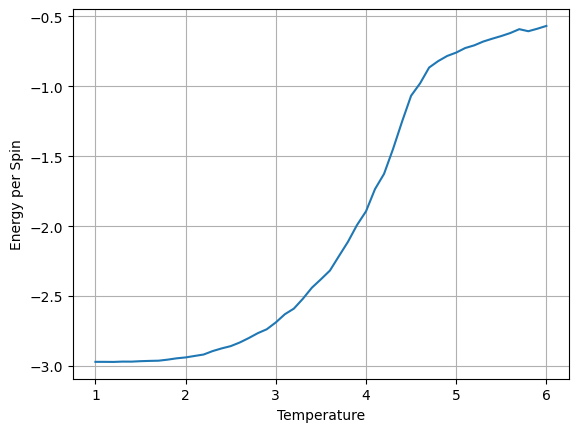

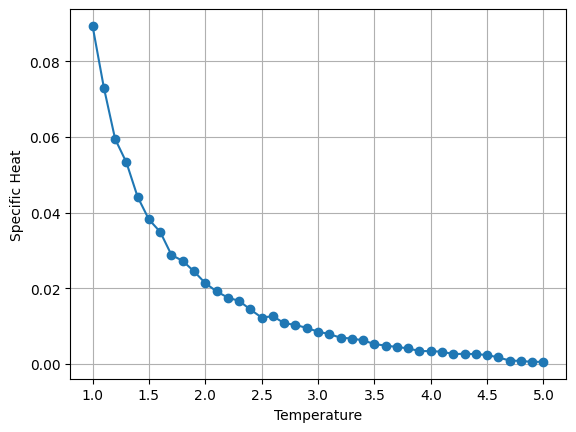

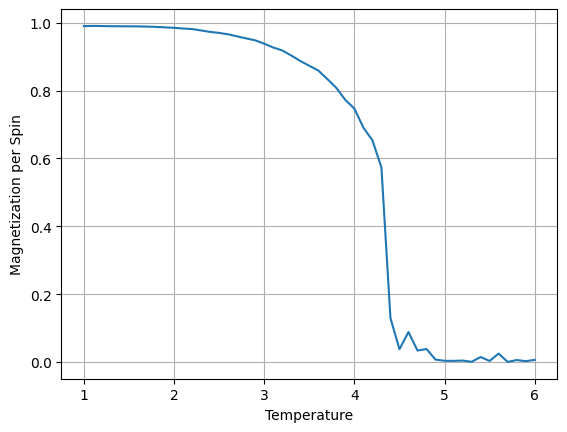

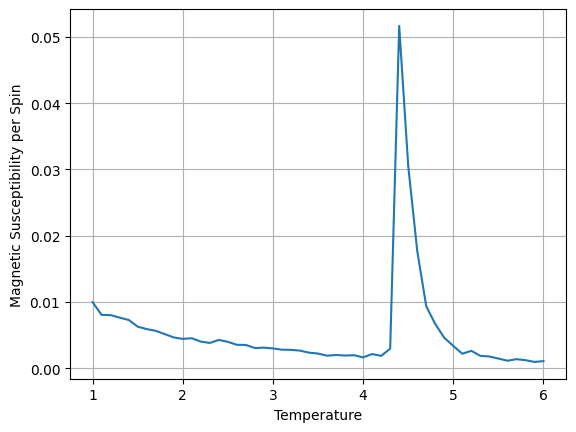

In [19]:
file_name = "output_mpa_1000_1000_25-06-03-11-24-39.csv"

temp_array, energy_by_T_array, magnetization_by_T_array, specific_heat_by_T_array, susceptibility_by_T_array = np.genfromtxt(file_name, delimiter=',',skip_header=1, unpack=True, dtype=float)


plt.plot(temp_array, energy_by_T_array)
plt.xlabel("Temperature")
plt.ylabel("Energy per Spin")
plt.grid()

plt.show()


plt.plot(temp_array[10:], specific_heat_by_T_array[10:], marker='o')
plt.xlabel("Temperature")
plt.ylabel("Specific Heat")
plt.grid()

plt.show()


plt.plot(temp_array, magnetization_by_T_array)
plt.xlabel("Temperature")
plt.ylabel("Magnetization per Spin")
plt.grid()

plt.show()


plt.plot(temp_array, susceptibility_by_T_array)
plt.xlabel("Temperature")
plt.ylabel("Magnetic Susceptibility per Spin")
plt.grid()

plt.show()

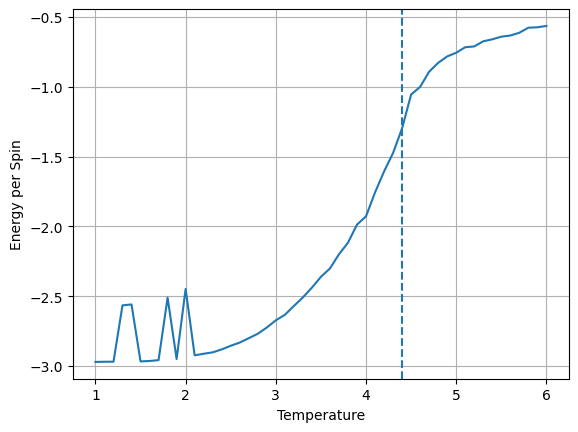

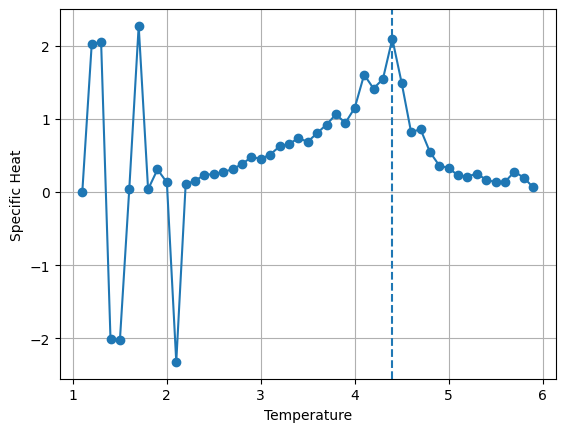

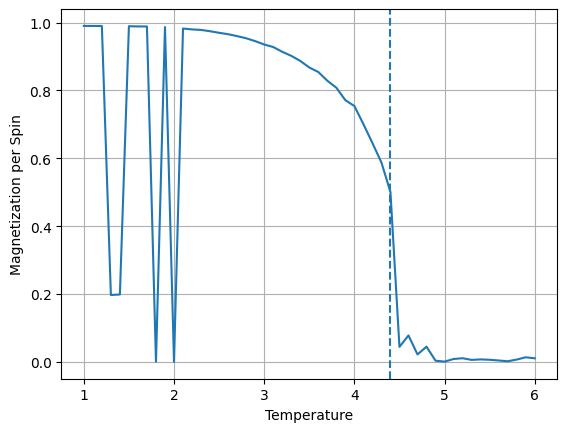

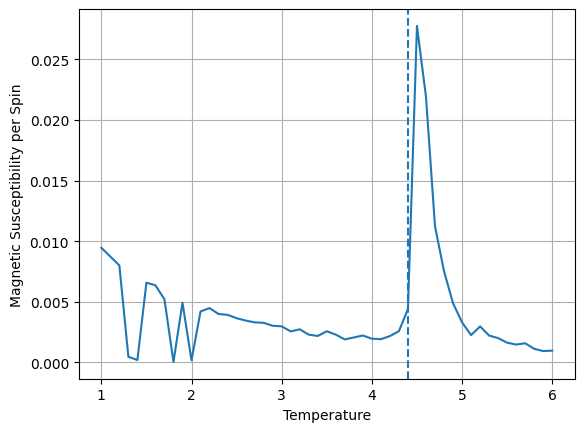

In [28]:
file_name = "output_mpa_1000_1000_1_-0.1_6_25-06-03-12-04-29.csv"

temp_array, energy_by_T_array, magnetization_by_T_array, specific_heat_by_T_array, susceptibility_by_T_array = np.genfromtxt(file_name, delimiter=',',skip_header=1, unpack=True, dtype=float)

# print("temp_array:")
# print(len(temp_array))
# print("\nenergy_by_T_array:")
# print(len(energy_by_T_array))
# print("\nmagnetization_by_T_array:")
# print(len(magnetization_by_T_array))
# spicic_heat_fwd_array = forward_difference_derivative(temp_array, energy_by_T_array)
# spicic_heat_bck_array = backward_difference_derivative(temp_array, energy_by_T_array)


plt.plot(temp_array, energy_by_T_array)
plt.xlabel("Temperature")
plt.ylabel("Energy per Spin")
plt.axvline(x=4.4, linestyle='--')
plt.grid()

plt.show()


spicic_heat_cnt_array = central_difference_derivative(temp_array, energy_by_T_array)


# plt.plot(temp_array[:len(temp_array) - 1], spicic_heat_fwd_array, marker='o')
# plt.plot(temp_array[:len(temp_array) - 1], spicic_heat_bck_array, marker='o')
plt.plot(temp_array[1:len(temp_array) - 1], spicic_heat_cnt_array, marker='o')
plt.xlabel("Temperature")
plt.ylabel("Specific Heat")
plt.axvline(x=4.4, linestyle='--')
plt.grid()

plt.show()


plt.plot(temp_array, magnetization_by_T_array)
plt.xlabel("Temperature")
plt.ylabel("Magnetization per Spin")
plt.axvline(x=4.4, linestyle='--')
plt.grid()

plt.show()

plt.plot(temp_array, susceptibility_by_T_array)
plt.xlabel("Temperature")
plt.ylabel("Magnetic Susceptibility per Spin")
plt.axvline(x=4.4, linestyle='--')
plt.grid()

plt.show()